In [1]:
# from buqeyemodel.pymc3_additions import MatNormal
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.multivariate import MatrixNormal as MatNormal
from pymc3.gp.util import plot_gp_dist
import theano
import theano.tensor as tt
%matplotlib inline

# MatNormal Testing

## Introduction
Suppose we are calculating the value of a scalar quantity $Z$ up to some order $k$ in an expansion. The value of $Z$ up to $k$th order is denoted $Z_k$ and we can make explicit the contribution from each order by writing it as
\begin{align}
    Z_k & = Z_0 + \Delta Z_1 + \cdots \Delta Z_k \\
    & = Z_{\text{ref}} (c_0 + c_1 Q + \cdots + c_k Q^k)
\end{align}
Where the $c_n$ are assumed to be draws of the same Gaussian process and $Q$ is some unknown scalar between 0 and 1. (The fact that we expect each contribution to get smaller in such a manner is informed by theory.) If all $Z_n$ are known, then $c_n Q^n$ can be found for any $n$ via
\begin{align}
    c_0 = \frac{Z_0}{Z_{\text{ref}}}, \qquad c_n Q^n = \frac{\Delta Z_n}{Z_{\text{ref}}} = \frac{Z_n - Z_{n-1}}{Z_{\text{ref}}}
\end{align}
If we have data in the form of the right-hand-sides of the above equations, then we should be able to determine both the Gaussian process hyperparameters for the $c_n$ and the expansion parameter $Q$. To do so, let's draw some fake realizations from a GP, scale each $c_n$ by $Q^n$ for some known $Q$, and then try to work backwards to determine the true values.

## Generate Data

In [2]:
# Initialize random number generator
rand_seed = 140
np.random.seed(rand_seed)
trace_sample = 1000
trace_tune = 700
trace_seed = 100

dim = 1
c = []
data = []
data_approx = []
k = 5
N = 20

powers = list(range(2, k+1))

# Domain values
X = np.linspace(0, 10, N)[:, None]

# True parameter values
sd_true = 1
ls_true = 3
Q_true = 1.0/600
Q_approx = 1.0/600
noise = 1e-9

# define gp, true parameter values
with pm.Model() as model:
    cov_true = sd_true**2 * pm.gp.cov.ExpQuad(dim, ls_true)
    K_noise = noise * tt.eye(N)
    K_true = cov_true(X) + K_noise

# evaluate the covariance with the given hyperparameters
K_true = theano.function([], K_true)()

for n in powers:
    # generate fake data from GP
    curve_pts = np.random.multivariate_normal(np.zeros(N), K_true)
    c.append(curve_pts)
    data.append(curve_pts * Q_true**n)
    data_approx.append(curve_pts * (Q_true/Q_approx)**n)

c = np.array(c)
data = np.array(data)
data_approx = np.array(data_approx)
# print(c)

Below we will plot the true $c_n$ data, that is, true realizations from the Gaussian process, along with the data that one would have in practice, that is the scaled values $c_n Q^n$.

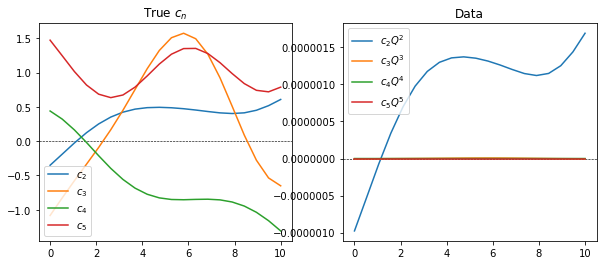

In [3]:
fig = plt.figure(figsize=(10, 4))
ax_cn = fig.add_subplot(121)
ax_data = fig.add_subplot(122)
ax_cn.axhline(y=0, ls='--', lw=0.6, c='k')
ax_data.axhline(y=0, ls='--', lw=0.6, c='k')
for i, n in enumerate(powers):
    ax_cn.plot(X[:, 0], c[i], label=r'$c_{}$'.format(n))
    ax_data.plot(X[:, 0], data[i], label=r'$c_{n}Q^{n}$'.format(n=n))

ax_cn.set_title('True $c_n$')
ax_cn.legend()
ax_data.set_title('Data')
ax_data.legend()

The data clearly get small quite quickly if $Q$ is small, which can cause issues with the sampling performed below. This is ok, because we usually have *some* idea of what $Q$ is, and can scale the data to some reasonable range by dividing by our approximation $Q_{\text{approx}}$, so long as we take this artificial scaling into account later on.

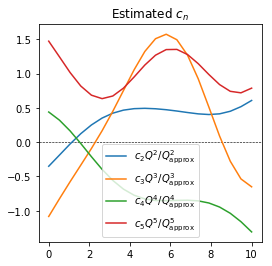

In [4]:
fig = plt.figure(figsize=(4, 4))
ax_approx = fig.add_subplot(111)
ax_approx.axhline(y=0, ls='--', lw=0.6, c='k')
for i, n in enumerate(powers):
    ax_approx.plot(X[:, 0], data_approx[i], label=r'$c_{n}Q^{n}/Q_{approx}^{n}$'.format(n=n, approx='{\mathrm{approx}}'))

ax_approx.set_title('Estimated $c_n$')
ax_approx.legend()

## MatNormal Testing
This looks better. Now let's build a model in PyMC3 and try to recover the input parameters using a matrix-valued normal distribution.

In [43]:
with pm.Model() as MatNormal_model:
    # Build covariance matrix for the curves
    sd = pm.Lognormal('sd', mu=np.log(sd_true), sd=10, testval=sd_true)
#     ls = ls_true
    ls = pm.Lognormal('ls', mu=np.log(ls_true), sd=0.2)
    cov = sd**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls)
    cov_mat = cov(X) + np.diag(noise*np.ones(len(X)))
    
    # Build covariance between curves themselves. Here is just diagonal matrix with Q^n along diagonal.
    Q = pm.Lognormal('Q', mu=np.log(Q_approx), sd=0.5, testval=Q_approx)
    norm_Q = Q/Q_approx  # Scale Q to account for artificial scaling.
    Qs = [norm_Q**(2*n) for n in powers]
    Qs_diag = tt.nlinalg.diag(Qs)
    
    obs = MatNormal(
            'obs', mu=0, rcov=cov_mat, lcov=Qs_diag,
            observed=data_approx,  # Be sure to use artificial scaled data to ease sampling.
            shape=(len(powers), len(X))
            )

In [44]:
with MatNormal_model:
    MatNormal_trace = pm.sample(trace_sample, tune=trace_tune, random_seed=trace_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1700/1700 [00:19<00:00, 87.83it/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c262f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e27a0b8>]], dtype=object)

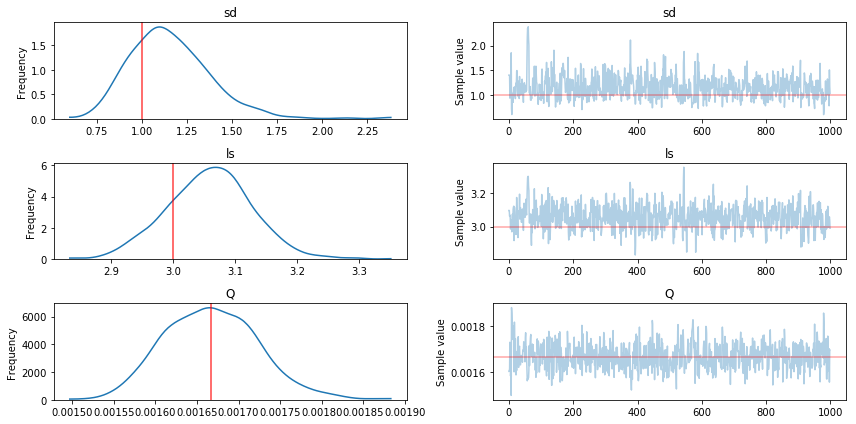

In [40]:
pm.traceplot(MatNormal_trace, varnames=[sd, ls, Q], lines={sd: sd_true, ls: ls_true, Q: Q_true})
# pm.traceplot(MatNormal_trace, varnames=[sd, Q], lines={sd: sd_true, Q: Q_true})

## MvNormal Testing
Now let's see if this agrees with (and is faster than) the method with a for loop. I remember there being weird effects (biasing both `sd` and `Q`) when I accidentally used $Q^n * (K + \sigma^2 \mathbf{I})$ instead of $Q^n K + \sigma^2 \mathbf{I}$ in previous testing. Does that still appear here?

## Total Cov = $Q^n K + \sigma^2 \mathbf{I}$

In [8]:
with pm.Model() as MvNormal_model:
    # Build covariance matrix for the curves
    sd2 = pm.Lognormal('sd2', mu=np.log(sd_true), sd=10, testval=sd_true)
#     ls = ls_true
    ls2 = pm.Lognormal('ls2', mu=np.log(ls_true), sd=0.2)
    cov2 = sd2**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls2)
    
    # Build covariance between curves themselves. Here is just diagonal matrix with Q^n along diagonal.
    Q2 = pm.Lognormal('Q2', mu=np.log(Q_approx), sd=0.5, testval=Q_approx)
    norm_Q = Q2/Q_approx  # Scale Q to account for artificial scaling.
    for i, n in enumerate(powers):
#         scaled_cov = norm_Q**(2*n) * cov
        scaled_cov_mat = norm_Q**(2*n) * cov2(X) + np.diag(noise*np.ones(len(X)))
        pm.MvNormal('obs2{}'.format(n), mu=0, cov=scaled_cov_mat, observed=data_approx[i])

In [9]:
with MvNormal_model:
    MvNormal_trace = pm.sample(trace_sample, tune=trace_tune, random_seed=trace_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1700/1700 [00:57<00:00, 29.46it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117359780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119488908>]], dtype=object)

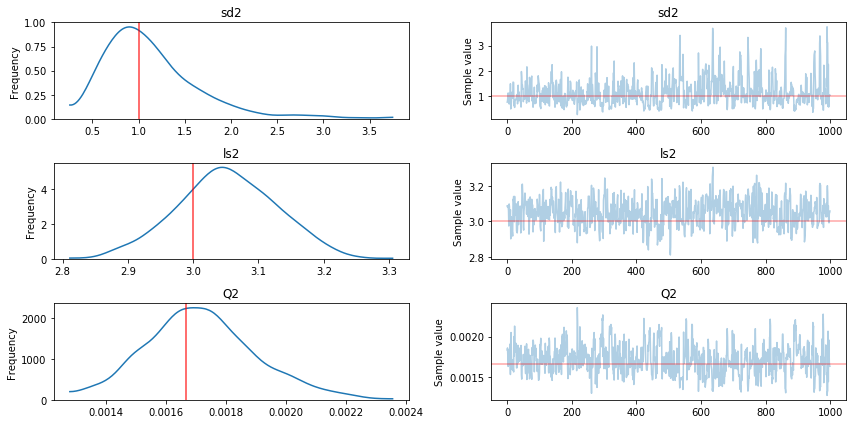

In [10]:
pm.traceplot(MvNormal_trace, varnames=[sd2, ls2, Q2], lines={sd2: sd_true, ls2: ls_true, Q2: Q_true})
# pm.traceplot(MvNormal_trace, varnames=[sd, Q], lines={sd: sd_true, Q: Q_true})

## Total Cov = $Q^n (K + \sigma^2 \mathbf{I})$

In [11]:
with pm.Model() as MvNormal_model2:
    # Build covariance matrix for the curves
    sd3 = pm.Lognormal('sd3', mu=np.log(sd_true), sd=10, testval=sd_true)
#     ls = ls_true
    ls3 = pm.Lognormal('ls3', mu=np.log(ls_true), sd=0.2)
    cov3 = sd3**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ls3)
    
    # Build covariance between curves themselves. Here is just diagonal matrix with Q^n along diagonal.
    Q3 = pm.Lognormal('Q3', mu=np.log(Q_approx), sd=0.5, testval=Q_approx)
    norm_Q = Q3/Q_approx  # Scale Q to account for artificial scaling.
    for i, n in enumerate(powers):
        scaled_cov_mat = norm_Q**(2*n) * (cov3(X) + np.diag(noise*np.ones(len(X))))
        pm.MvNormal('obs3{}'.format(n), mu=0, cov=scaled_cov_mat, observed=data_approx[i])

In [12]:
with MvNormal_model2:
    MvNormal_trace2 = pm.sample(trace_sample, tune=trace_tune, random_seed=trace_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1700/1700 [00:34<00:00, 49.10it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1193125f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x118b2e320>]], dtype=object)

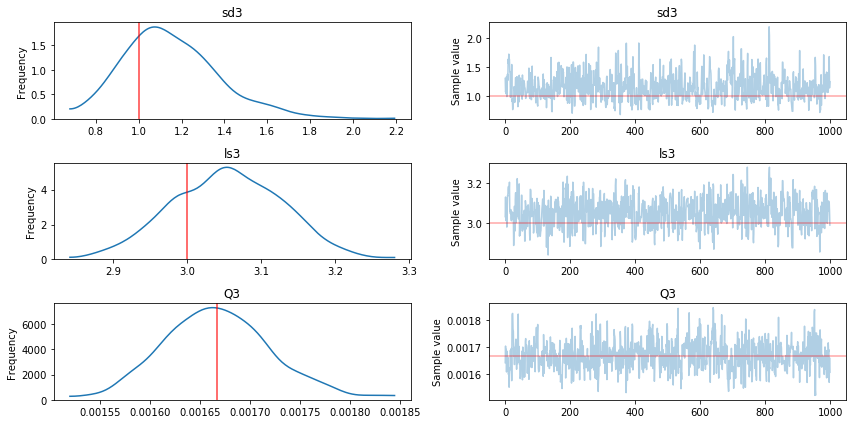

In [13]:
pm.traceplot(MvNormal_trace2, varnames=[sd3, ls3, Q3], lines={sd3: sd_true, ls3: ls_true, Q3: Q_true})
# pm.traceplot(MvNormal_trace2, varnames=[sd, Q], lines={sd: sd_true, Q: Q_true})

# Conclusions

The `MatNormal` class seems to work as expected, and about twice as fast (or more) than the `for` loop version of `MvNormal`. I could not reproduce the issues I was experiencing before when I using $Q^n * (K + \sigma^2 \mathbf{I})$ instead of $Q^n K + \sigma^2 \mathbf{I}$. I do not know if/how `MatNormal` or something like it could be merged with the current `GP` api of PyMC3 to allow for Coregional effects, but it would be nice if it could be.